Import statements, and define a utility plotting function

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, roc_auc_score, roc_curve


def plot_confusion_matrix(y_true, y_pred, **kwargs):
    sns.set_style("whitegrid")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, **kwargs)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

Read in the data, and inspect

In [16]:
diabetes = pd.read_csv("diabetes.csv")

diabetes.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [17]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BloodPressure'}>],
       [<AxesSubplot:title={'center':'SkinThickness'}>,
        <AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Outcome'}>]], dtype=object)

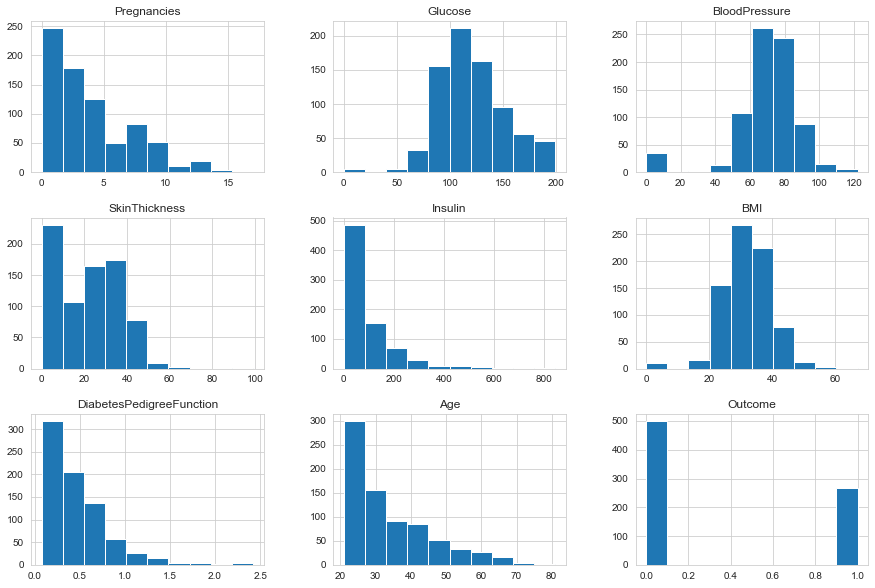

In [18]:
diabetes.hist(figsize=(15, 10))

In [19]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Visualize correlation matrix of features

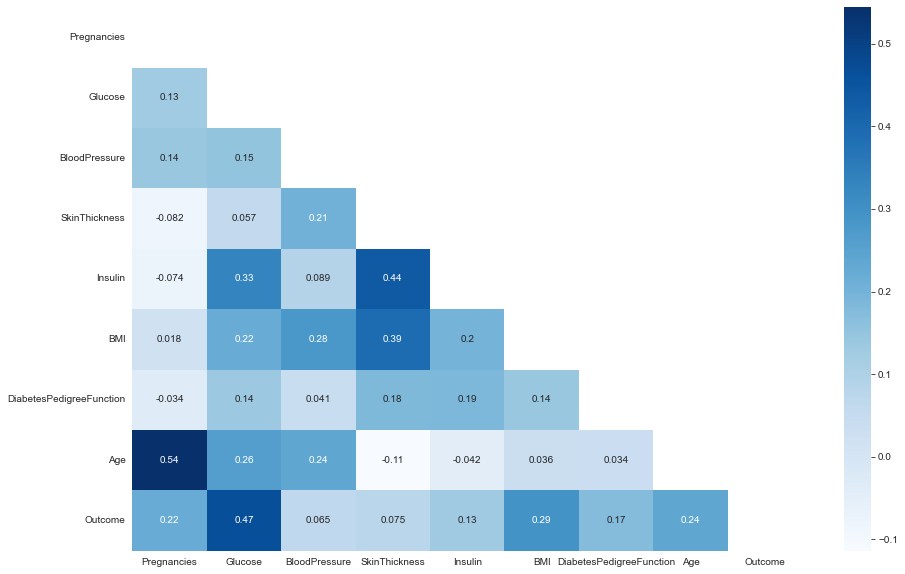

In [20]:
fig, ax = plt.subplots(figsize=(15, 10))

mask = np.triu(np.ones_like(diabetes.corr()))

# Plot a triangular correlation matrix
dataplot = sns.heatmap(diabetes.corr(), cmap="Blues", annot=True, mask=mask)
plt.show()

From inspection it appears there a couple of things we need to do. "Glucose", "BloodPressure", "SkinThickness", "Insulin", and "BMI" each have have many spurious values of zero. As this is incompatible with human-life, they must be in error. Replace them via mean-imputation

Also break out the "Outcome" column, which is the dependent variable to be predicted.

array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BloodPressure'}>],
       [<AxesSubplot:title={'center':'SkinThickness'}>,
        <AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>,
        <AxesSubplot:title={'center':'Age'}>, <AxesSubplot:>]],
      dtype=object)

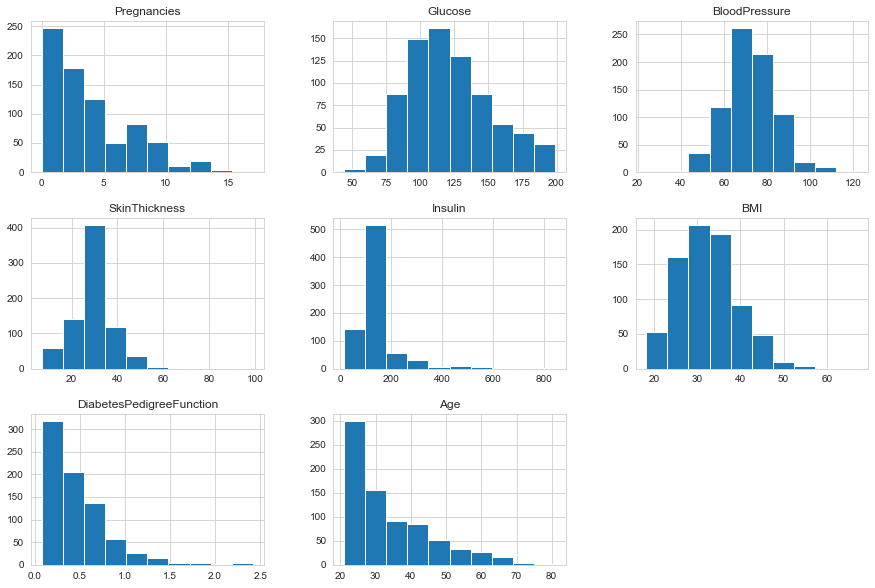

In [21]:
imp = SimpleImputer(missing_values=0)

imputed_diabetes = diabetes.copy()
imputed_diabetes[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = imp.fit_transform(diabetes[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']])
outcome = imputed_diabetes.pop("Outcome")

imputed_diabetes.hist(figsize=(15, 10))

Now the data are looking more appriopriate, split into training and test sets

In [22]:
X_train, X_test, y_train, y_test = train_test_split(imputed_diabetes, outcome, test_size=0.25, random_state=77)

Fit a Gaussian Naive Bayes model, as well as an unpenalized logistic regression for comparison

In [23]:
gnb = GaussianNB()

gnb.fit(X_train, y_train)
print("Naive Bayes Training Summary")
print("============================")
print(f"Means: {gnb.theta_}")
print(f"Variances: {gnb.var_}")
print(f"In-sample accuracy: {gnb.score(X_train, y_train):.3f}")

Naive Bayes Training Summary
Means: [[  3.22888283 109.12090879  70.13158941  27.59284703 136.84522608
   30.88731548   0.42707629  30.74386921]
 [  4.70334928 143.90609342  75.30465349  31.42975528 182.15272144
   35.14791831   0.55060766  37.02392344]]
Variances: [[9.25552054e+00 5.89606389e+02 1.30171051e+02 7.42794253e+01
  3.90843442e+03 3.85288755e+01 8.17549565e-02 1.27422141e+02]
 [1.32038704e+01 8.41200571e+02 1.39362996e+02 8.03523068e+01
  8.31355104e+03 3.53763509e+01 1.29722067e-01 1.19956371e+02]]
In-sample accuracy: 0.760


In [24]:
lr = LogisticRegression(penalty='none', max_iter=1000)

lr.fit(X_train, y_train)
print("Logistic Regression Training Summary")
print("====================================")
print(f"Number of Iterations: {lr.n_iter_}")
print(f"Coefficients: {lr.coef_}")
print(f"In-sample accuracy: {lr.score(X_train, y_train):.3f}")

Logistic Regression Training Summary
Number of Iterations: [134]
Coefficients: [[ 1.05197064e-01  4.20332347e-02  2.25478199e-03 -7.20850884e-03
   8.66405346e-04  1.01474814e-01  1.41642546e+00  1.75668331e-02]]
In-sample accuracy: 0.785


Assess the out-of-sample performances of both models

Gaussian Naive Bayes Report
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       133
           1       0.53      0.59      0.56        59

    accuracy                           0.71       192
   macro avg       0.67      0.68      0.67       192
weighted avg       0.72      0.71      0.72       192



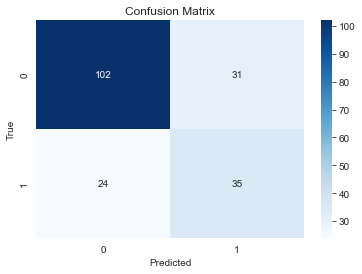


Logistic Regression Report
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       133
           1       0.61      0.56      0.58        59

    accuracy                           0.76       192
   macro avg       0.71      0.70      0.71       192
weighted avg       0.75      0.76      0.75       192



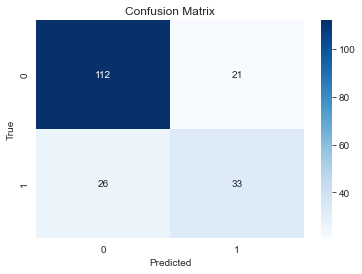

Model Comparison
Out-of-Sample Accuracy: GaussianNB - 0.714; Logistic Regression - 0.755
Matthews Correlation Coefficient: GaussianNB - 0.350; Logistic Regression - 0.412
Out-of-Sample AUC: GaussianNB - 0.746; Logistic Regression - 0.781


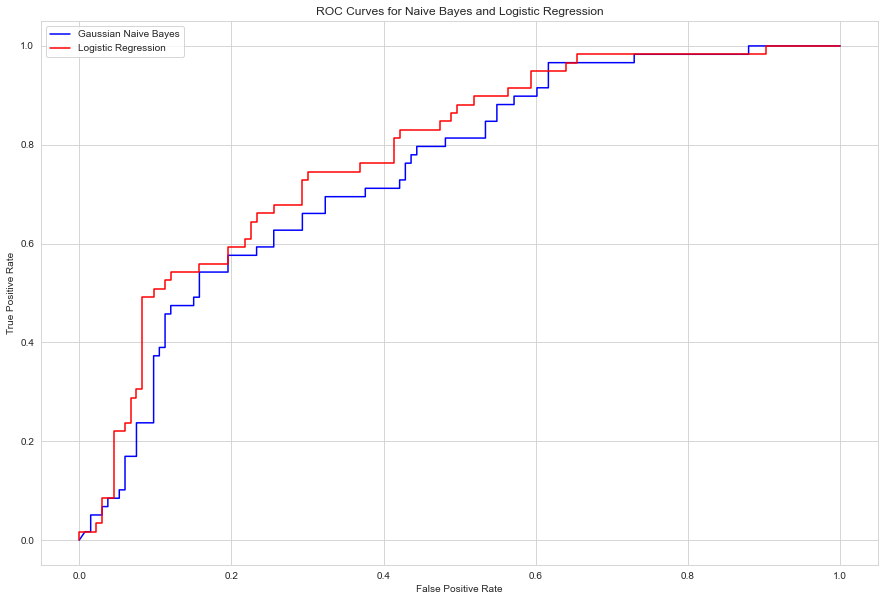

In [25]:
y_pred_nb = gnb.predict(X_test)
nb_pred_probs = gnb.predict_proba(X_test)

y_pred_lr = lr.predict(X_test)
lr_pred_probs = lr.predict_proba(X_test)

# Visualize results for Naive Bayes
print("Gaussian Naive Bayes Report")
print("===========================")
print(classification_report(y_test, y_pred_nb))
plot_confusion_matrix(y_test, y_pred_nb, annot=True, cmap="Blues", fmt="d")

# Visualize results for Logistic Regression
print("\nLogistic Regression Report")
print("==========================")
print(classification_report(y_test, y_pred_lr))

plot_confusion_matrix(y_test, y_pred_lr, annot=True, cmap="Blues", fmt="d")

# Visualize comparison of two models
print("Model Comparison")
print("================")
print(f"Out-of-Sample Accuracy: GaussianNB - {gnb.score(X_test, y_test):.3f}; Logistic Regression - {lr.score(X_test, y_test):.3f}")
print(f"Matthews Correlation Coefficient: GaussianNB - {matthews_corrcoef(y_test, y_pred_nb):.3f}; Logistic Regression - {matthews_corrcoef(y_test, y_pred_lr):.3f}")
print(f"Out-of-Sample AUC: GaussianNB - {roc_auc_score(y_test, nb_pred_probs[:,1]):.3f}; Logistic Regression - {roc_auc_score(y_test, lr_pred_probs[:,1]):.3f}")

nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_pred_probs[:,1])
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_pred_probs[:,1])

plt.figure(figsize=(15, 10))
plt.plot(nb_fpr, nb_tpr, color='blue', label="Gaussian Naive Bayes")
plt.plot(lr_fpr, lr_tpr, color='red', label="Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='upper left')

plt.title("ROC Curves for Naive Bayes and Logistic Regression")
plt.show()

Without any model-tuning, both models perform comparably, and neither does exceptionally well. Logistic regression does, however, outperform Naive Bayes by a small degree.

## **Feature Engineering**

Not every feature seems to be contributing equally to the outcome. Let's see if we can improve model performance by dropping unhelpful features

In [26]:
# Drop BloodPressure, SkinThickness, and Insulin. These have low correlation with outcome
# Probably because so much of the data in these fields is missing/imputed
# Impute the missing values in Glucose and BMI

feature_engineered_diabetes = diabetes.drop(columns=['BloodPressure', 'SkinThickness', 'Insulin'])
feature_engineered_diabetes[['Glucose', 'BMI']] = imp.fit_transform(feature_engineered_diabetes[['Glucose', 'BMI']])

fe_outcome = feature_engineered_diabetes.pop('Outcome')

Split this into training and test sets, fit another Gaussian Naive Bayes model

In [27]:
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(feature_engineered_diabetes, fe_outcome, random_state=77)

gnb2 = GaussianNB()
gnb2.fit(new_X_train, new_y_train)
print("Model Training Summary")
print("======================")
print(f"Means: {gnb.theta_}")
print(f"Variances: {gnb.var_}")
print(f"In-sample accuracy: {gnb2.score(new_X_train, new_y_train):.3f}")

Model Training Summary
Means: [[  3.22888283 109.12090879  70.13158941  27.59284703 136.84522608
   30.88731548   0.42707629  30.74386921]
 [  4.70334928 143.90609342  75.30465349  31.42975528 182.15272144
   35.14791831   0.55060766  37.02392344]]
Variances: [[9.25552054e+00 5.89606389e+02 1.30171051e+02 7.42794253e+01
  3.90843442e+03 3.85288755e+01 8.17549565e-02 1.27422141e+02]
 [1.32038704e+01 8.41200571e+02 1.39362996e+02 8.03523068e+01
  8.31355104e+03 3.53763509e+01 1.29722067e-01 1.19956371e+02]]
In-sample accuracy: 0.762


Classification Report
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       133
           1       0.64      0.61      0.63        59

    accuracy                           0.78       192
   macro avg       0.74      0.73      0.73       192
weighted avg       0.77      0.78      0.77       192



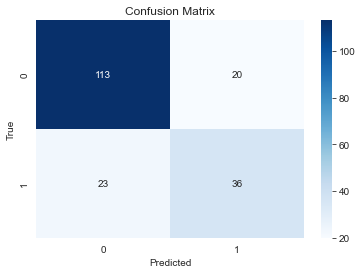

Out-of-Sample Performance
Accuracy: 0.776
Matthews Correlation: 0.467
AUC: 0.782


In [28]:
new_nb_y_pred = gnb2.predict(new_X_test)
new_nb_pred_probs = gnb2.predict_proba(new_X_test)[:,1]

print("Classification Report")
print("=====================")
print(classification_report(new_y_test, new_nb_y_pred))

plot_confusion_matrix(new_y_test, new_nb_y_pred, annot=True, cmap="Blues", fmt="d")

print("Out-of-Sample Performance")
print("=========================")
print(f"Accuracy: {gnb2.score(new_X_test, new_y_test):.3f}")
print(f"Matthews Correlation: {matthews_corrcoef(new_y_test, new_nb_y_pred):.3f}")
print(f"AUC: {roc_auc_score(new_y_test, new_nb_pred_probs):.3f}")

This is a marked improvement over the original model.